Task 4: Recommendation System
Creating sample ratings dataset...
Sample ratings dataset with 1637 ratings saved to 'ratings_dataset.csv'

Building recommendation system...
Creating user-item matrix...
User-item matrix shape: (100, 50)
Splitting data into training and testing sets...
Performing matrix factorization using SVD...
Evaluating model...
Root Mean Square Error (RMSE): 2.9946
Error distribution visualization saved to 'recommendation_errors.png'
Actual vs predicted ratings visualization saved to 'actual_vs_predicted.png'

Top 10 recommendations for User 1:
Item 41 - Predicted Rating: 1.32
Item 33 - Predicted Rating: 1.21
Item 23 - Predicted Rating: 0.89
Item 8 - Predicted Rating: 0.86
Item 6 - Predicted Rating: 0.70
Item 3 - Predicted Rating: 0.66
Item 17 - Predicted Rating: 0.60
Item 1 - Predicted Rating: 0.59
Item 47 - Predicted Rating: 0.47
Item 13 - Predicted Rating: 0.37
Top recommendations visualization saved to 'top_recommendations.png'

Task completed successfully!


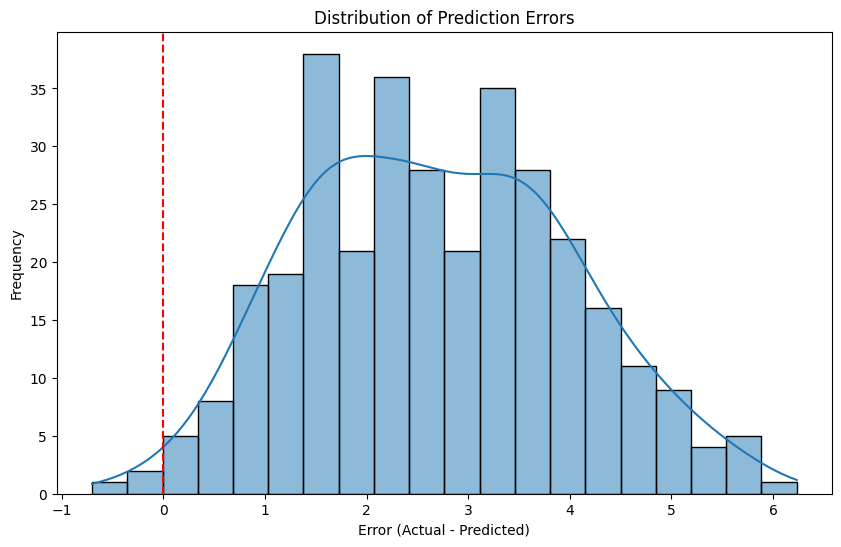

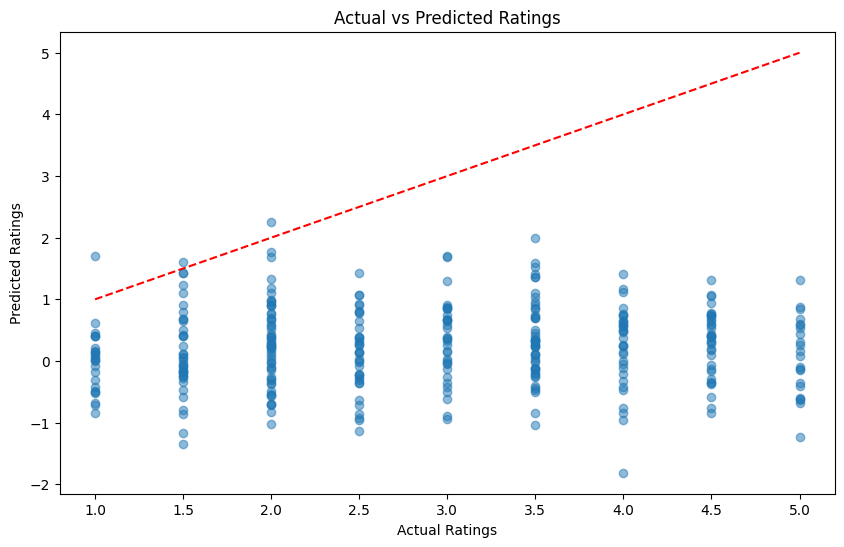

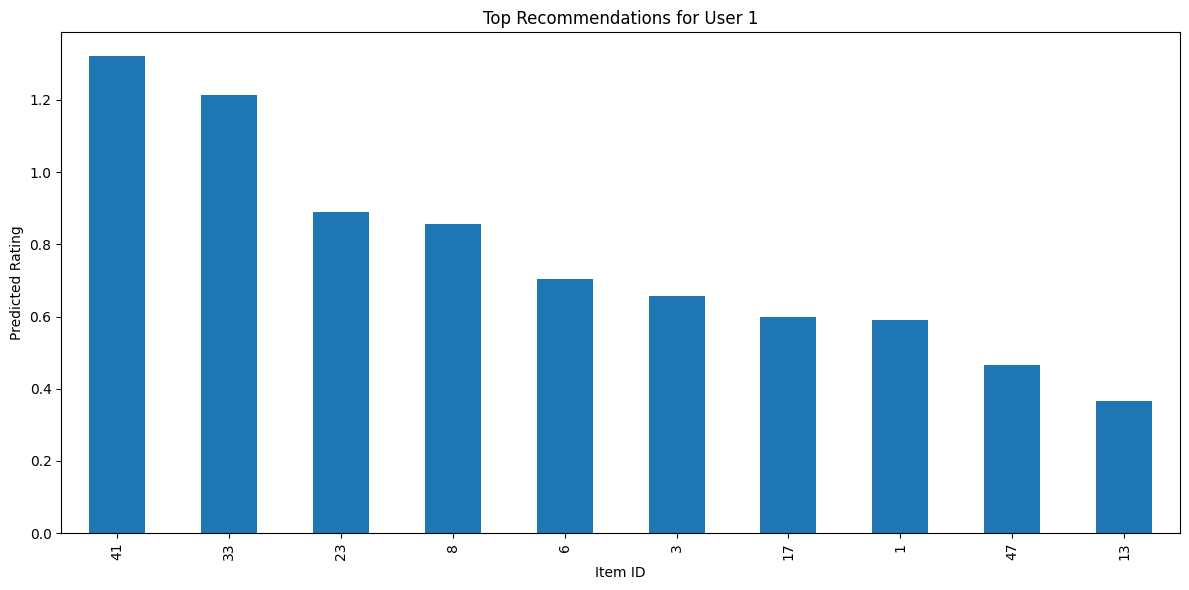

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

# Create a function to generate and save a sample ratings dataset
def create_ratings_dataset(num_users=100, num_items=50, num_ratings=2000):
    print("Creating sample ratings dataset...")

    # Generate random user-item interactions
    np.random.seed(42)
    user_ids = np.random.randint(1, num_users + 1, size=num_ratings)
    item_ids = np.random.randint(1, num_items + 1, size=num_ratings)

    # Ensure unique user-item pairs
    pairs = set()
    unique_user_ids = []
    unique_item_ids = []

    for i in range(num_ratings):
        user_id = user_ids[i]
        item_id = item_ids[i]
        pair = (user_id, item_id)

        if pair not in pairs:
            pairs.add(pair)
            unique_user_ids.append(user_id)
            unique_item_ids.append(item_id)

    # Generate ratings (1-5 scale)
    ratings = np.random.uniform(1, 5, size=len(unique_user_ids))
    ratings = np.round(ratings * 2) / 2  # Round to nearest 0.5

    # Generate timestamps
    timestamps = np.random.randint(1577836800, 1609459200, size=len(unique_user_ids))  # 2020 timestamps

    # Create DataFrame
    ratings_df = pd.DataFrame({
        'userId': unique_user_ids,
        'itemId': unique_item_ids,
        'rating': ratings,
        'timestamp': timestamps
    })

    # Save to CSV
    ratings_df.to_csv('ratings_dataset.csv', index=False)
    print(f"Sample ratings dataset with {len(ratings_df)} ratings saved to 'ratings_dataset.csv'")
    return ratings_df

# Main function to build recommendation system
def recommendation_system():
    # Create dataset if it doesn't exist
    try:
        ratings_df = pd.read_csv('ratings_dataset.csv')
        print("Loaded existing ratings dataset")
    except FileNotFoundError:
        ratings_df = create_ratings_dataset()

    print("\nBuilding recommendation system...")

    # Create user-item matrix
    print("Creating user-item matrix...")
    user_item_matrix = ratings_df.pivot(
        index='userId',
        columns='itemId',
        values='rating'
    ).fillna(0)

    # Print matrix shape
    print(f"User-item matrix shape: {user_item_matrix.shape}")

    # Split data into training and testing sets
    print("Splitting data into training and testing sets...")
    train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)

    # Create training user-item matrix
    train_user_item_matrix = train_data.pivot(
        index='userId',
        columns='itemId',
        values='rating'
    ).fillna(0)

    # Get all users and items
    all_users = user_item_matrix.index.unique()
    all_items = user_item_matrix.columns.unique()

    # Fill in missing users and items in training matrix
    for user in all_users:
        if user not in train_user_item_matrix.index:
            train_user_item_matrix.loc[user] = np.zeros(len(train_user_item_matrix.columns))

    for item in all_items:
        if item not in train_user_item_matrix.columns:
            train_user_item_matrix[item] = np.zeros(len(train_user_item_matrix.index))

    # Calculate user means
    user_means = train_user_item_matrix.mean(axis=1)

    # Normalize the data by subtracting user means
    train_matrix_normalized = train_user_item_matrix.sub(user_means, axis=0)

    # Convert to numpy array
    train_matrix_np = train_matrix_normalized.to_numpy()

    # Perform matrix factorization using SVD
    print("Performing matrix factorization using SVD...")
    num_factors = 20  # Number of latent factors
    U, sigma, Vt = svds(train_matrix_np, k=num_factors)

    # Convert sigma to diagonal matrix
    sigma_diag = np.diag(sigma)

    # Reconstruct the matrix
    predicted_ratings = np.dot(np.dot(U, sigma_diag), Vt) + user_means.values.reshape(-1, 1)

    # Convert back to DataFrame
    predicted_ratings_df = pd.DataFrame(
        predicted_ratings,
        index=train_user_item_matrix.index,
        columns=train_user_item_matrix.columns
    )

    # Evaluate the model using RMSE on test data
    print("Evaluating model...")
    test_user_item_pairs = list(zip(test_data['userId'], test_data['itemId']))
    actual_ratings = test_data['rating'].values
    predicted_ratings_list = []

    for user_id, item_id in test_user_item_pairs:
        if user_id in predicted_ratings_df.index and item_id in predicted_ratings_df.columns:
            pred_rating = predicted_ratings_df.loc[user_id, item_id]
            predicted_ratings_list.append(pred_rating)
        else:
            # If user or item not in training data, use the global mean
            predicted_ratings_list.append(train_data['rating'].mean())

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings_list))
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

    # Visualize the distribution of errors
    errors = actual_ratings - predicted_ratings_list

    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=20)
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.savefig('recommendation_errors.png', dpi=300)
    print("Error distribution visualization saved to 'recommendation_errors.png'")

    # Visualize actual vs predicted ratings
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_ratings, predicted_ratings_list, alpha=0.5)
    plt.plot([min(actual_ratings), max(actual_ratings)], [min(actual_ratings), max(actual_ratings)], 'r--')
    plt.title('Actual vs Predicted Ratings')
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.savefig('actual_vs_predicted.png', dpi=300)
    print("Actual vs predicted ratings visualization saved to 'actual_vs_predicted.png'")

    # Function to get top N recommendations for a user
    def get_top_recommendations(user_id, n=10):
        if user_id not in predicted_ratings_df.index:
            print(f"User {user_id} not found in the dataset.")
            return []

        # Get user's ratings
        user_ratings = user_item_matrix.loc[user_id]

        # Get items the user hasn't rated
        unrated_items = user_ratings[user_ratings == 0].index.tolist()

        # Get predicted ratings for unrated items
        predicted_user_ratings = predicted_ratings_df.loc[user_id]

        # Sort the predictions for unrated items
        recommended_items = predicted_user_ratings[unrated_items].sort_values(ascending=False)

        return recommended_items.head(n)

    # Example: Get recommendations for a specific user
    example_user_id = user_item_matrix.index[0]  # First user in the dataset
    recommendations = get_top_recommendations(example_user_id, 10)

    print(f"\nTop 10 recommendations for User {example_user_id}:")
    for item_id, predicted_rating in recommendations.items():
        print(f"Item {item_id} - Predicted Rating: {predicted_rating:.2f}")

    # Visualize the top recommendations
    plt.figure(figsize=(12, 6))
    recommendations.plot(kind='bar')
    plt.title(f'Top Recommendations for User {example_user_id}')
    plt.xlabel('Item ID')
    plt.ylabel('Predicted Rating')
    plt.tight_layout()
    plt.savefig('top_recommendations.png', dpi=300)
    print("Top recommendations visualization saved to 'top_recommendations.png'")

    return predicted_ratings_df

if __name__ == "__main__":
    print("Task 4: Recommendation System")
    print("============================")
    model = recommendation_system()
    print("\nTask completed successfully!")